In [4]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10)
matplotlib.rcParams.update({'font.size': 20})
import pandas as pd
from virgodb import VirgoDB
vdb = VirgoDB("giorgio",password="BN401kmd")
import time

# COSMOLOGY

In [21]:
def integ_trap(func,z1,z2,N=1000):
    z = np.logspace(np.log10(z1),np.log10(z2),N)
    y = func(z)

    A = 0
    for i in range(len(z)-1):
        A += np.abs((z[i+1]-z[i]))*(y[i]+y[i+1])/2
    return A

def E(z,Om_rad=8.4*10**(-5),Om_lambda=0.7,Om_mat=0.3):
    return np.sqrt(Om_rad*(1+z)**4 + Om_mat*(1+z)**3 + Om_lambda)

def over_E(z):
    return E(z)**(-1)

def comoving_distance(z):
    zero = 10**(-20)
    c = 3e5 #km/s
    H0=100. #km/s/Mpc
    return (c*H0**(-1)*integ_trap(over_E,zero,z,10**(3))) #Mpc h^-1

vec_r = np.vectorize(comoving_distance)

def Luminosity_distance(z):
    '''Returns the Luminosity distance in units of Mpc h^-1'''
    return comoving_distance(z)*(1.+z)

def ABSOLUTE_MAGNITUDE_minus5logh(m,z,K_correction=False,ratio_L=1.):
    if K_correction:
        return m -25. -5.*np.log10(Luminosity_distance(z)) -2.5*np.log10(ratio_L*(1.+z))
    else:
        return m -25. -5.*np.log10(Luminosity_distance(z))

vec_ABSOLUTE_MAGNITUDE_minus5logh = np.vectorize(ABSOLUTE_MAGNITUDE_minus5logh)

# EDGE

In [22]:
def EDGE(x,y,x_min=-26.,x_max=-15.,x_bin_size=0.1,y_min=0.55,y_max=2.1,y_bin_size=0.15,threashold =0.15):
    '''It returns two arrays containing the x and y of the edge'''
    y_Nbins = int((y_max - y_min) / y_bin_size)
    x_Nbins = int((x_max - x_min) / x_bin_size)
    x_edge=[]
    y_edge=[]
    #loop on y bins
    for i in range(y_Nbins):
        # define y bin
        y_low = y_min + y_bin_size * i
        y_high = y_min + y_bin_size * (i+1)
        y_center = (y_low+y_high)/2.
        select_y_in_ybin = np.where((y>=y_low)&(y<y_high))
        # histogram of x in a selected y bin
        x_histo, x_histo_bins = np.histogram(x[select_y_in_ybin],bins=x_Nbins,range=(x_min,x_max))
        #find most populated bin
        x_histo_max = np.max(x_histo[:-1])
        x_histo_max_index = np.argmax(x_histo[:-1])
        #loop to find the edge
        for j in range(x_histo_max_index,0,-1):
            if (x_histo[j]<x_histo_max * threashold):
                edge_index = j
                break
        x_edge.append(x_histo_bins[j])
        y_edge.append(y_center)
    return np.array(x_edge), np.array(y_edge)

# QUERY

In [6]:
QJ = 'SELECT '
QJ += '   des.mag_V_ext as d_mag_V_ext, '
QJ += '   des.SDSS_u_ext as d_SDSS_u_ext, '
QJ += '   prog.mag_V_ext as p_mag_V_ext, '
QJ += '   prog.SDSS_u_ext as p_SDSS_u_ext, ' 
QJ += '   prog.stellarmass as p_stellarmass, '
QJ += '   des.stellarmass as d_stellarmass, '
QJ += '   des.SDSS_i_obs_ext as d_SDSS_i_obs_ext, '
QJ += '   prog.SDSS_i_obs_ext as p_SDSS_i_obs_ext '
QJ += 'FROM '
QJ += '   Gonzalez2014a..mr7 as des with(index(pk_mr7_galaxyid)), '
QJ += '   Gonzalez2014a..mr7 as prog with(forceseek,index(pk_mr7_galaxyid)) '
QJ += 'WHERE '
QJ += '   des.snapnum = 47 AND '
QJ += '   prog.galaxyid BETWEEN des.galaxyid AND des.mainleafid '
QJ += '   AND prog.snapnum = 37 '
QJ += '   AND des.stellarmass>0.1 '

t1 = time.time()
vdb.query_to_file("../data/prog_37_47_JohnHelly_0.txt", QJ, format="text")
t2 = time.time()

1399.34540987


In [11]:
print "Query time = ",(t2-t1)/60,"minutes"

Query time =  23.3224234978 minutes


# Read from file

In [12]:
john_0 = pd.read_csv("../data/prog_37_47_JohnHelly_0.txt",comment='#',delimiter=',')

In [13]:
john_0

,d_mag_V_ext,d_SDSS_u_ext,p_mag_V_ext,p_SDSS_u_ext,p_stellarmass,d_stellarmass,d_SDSS_i_obs_ext,p_SDSS_i_obs_ext
0,-17.518720,-15.999752,-18.441702,-17.028660,0.120607,0.121330,-17.422668,-16.863281
1,-19.425222,-17.410242,-19.043230,-17.296629,1.386015,1.432806,-19.283215,-17.147202
2,-20.045643,-18.006695,-20.241976,-18.347946,2.323335,2.332975,-19.906292,-18.190075
3,-19.805490,-17.846436,-20.422056,-18.575546,1.796550,1.798593,-19.670559,-18.419014
4,-17.585186,-15.931753,-18.317966,-16.727201,0.156179,0.156187,-17.475410,-16.566809
5,-18.517553,-16.731844,-19.263552,-17.560740,0.418510,0.418523,-18.397596,-17.408678
6,-18.994194,-17.207428,-19.736301,-18.024702,0.645596,0.645672,-18.874247,-17.871126
7,-19.190475,-17.369434,-19.821095,-18.055172,0.819289,0.819409,-19.067638,-17.900503
8,-18.860190,-17.051311,-19.515750,-17.785324,0.601387,0.601426,-18.738081,-17.632784
9,-18.476046,-16.676200,-19.114000,-17.400190,0.425506,0.425515,-18.354439,-17.247221


In [15]:
from astropy import cosmology

In [19]:
# I need to convert the absolute magnitudes in apparent magnitudes
help(cosmology.FlatLambdaCDM.luminosity_distance) 

Help on method luminosity_distance in module astropy.cosmology.core:

luminosity_distance(self, z) unbound astropy.cosmology.core.FlatLambdaCDM method
    Luminosity distance in Mpc at redshift ``z``.
    
    This is the distance to use when converting between the
    bolometric flux from an object at redshift ``z`` and its
    bolometric luminosity.
    
    Parameters
    ----------
    z : array-like
      Input redshifts.  Must be 1D or scalar.
    
    Returns
    -------
    d : `~astropy.units.Quantity`
      Luminosity distance in Mpc at each input redshift.
    
    See Also
    --------
    z_at_value : Find the redshift corresponding to a luminosity distance.
    
    References
    ----------
    Weinberg, 1972, pp 420-424; Weedman, 1986, pp 60-62.



In [23]:
print (ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46))

-18.771415990323533


# COLOUR MAGNITUDE

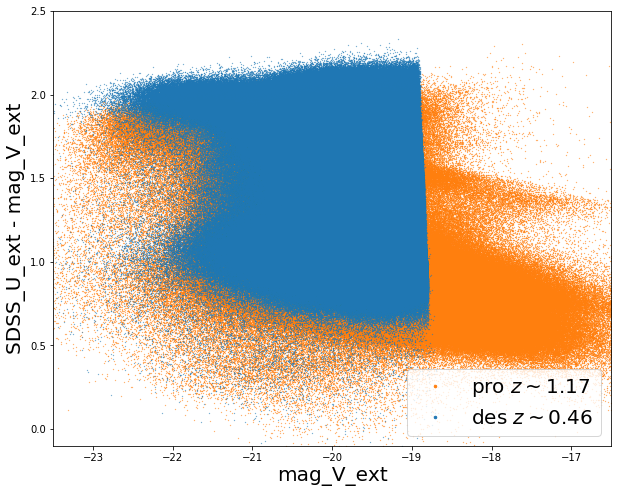

In [47]:
plt.figure(figsize=(10,8))


CUT_225 = np.where(john_0['d_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46))

xp = np.array(john_0['p_mag_V_ext'])[CUT_225]
yp = np.array(john_0['p_SDSS_u_ext'])[CUT_225]-np.array(john_0['p_mag_V_ext'])[CUT_225]

xd = np.array(john_0['d_mag_V_ext'])[CUT_225]
yd = np.array(john_0['d_SDSS_u_ext'])[CUT_225]-np.array(john_0['d_mag_V_ext'])[CUT_225]


plt.plot(xp,yp,".",markersize=0.5,label=r'pro $z\sim1.17$',c='C1')
plt.plot(xd,yd,".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')
plt.xlabel("mag_V_ext")
plt.ylabel("SDSS_U_ext - mag_V_ext")
plt.legend(markerscale=10)

plt.xlim(-23.5,-16.5)
plt.ylim(-0.1,2.5)

plt.savefig("../plots/009/col_mag_des_prog_cut225.png")
plt.show()

In [46]:
CUT_225[0][10:20]

array([20, 21, 22, 23, 24, 26, 30, 31, 32, 33])

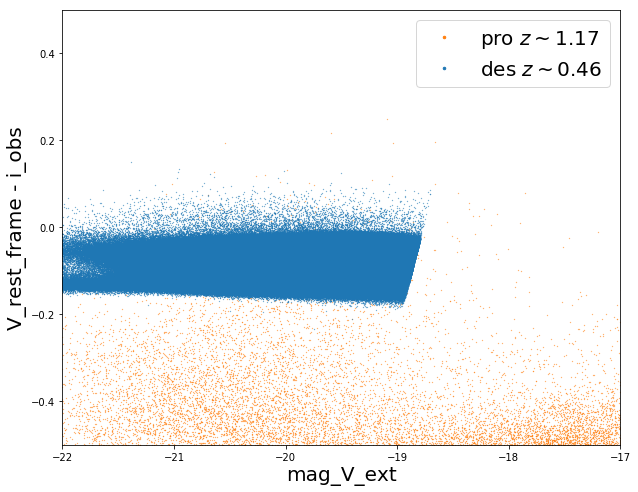

In [43]:
plt.figure(figsize=(10,8))


CUT_225 = np.where(john_0['d_SDSS_i_obs_ext']<ABSOLUTE_MAGNITUDE_minus5logh(22.5,0.46))

xp = np.array(john_0['p_mag_V_ext'])[CUT_225]
yp = np.array(john_0['p_mag_V_ext'])[CUT_225]-np.array(john_0['p_SDSS_i_obs_ext'])[CUT_225]

xd = np.array(john_0['d_mag_V_ext'])[CUT_225]
yd = np.array(john_0['d_mag_V_ext'])[CUT_225]-np.array(john_0['d_SDSS_i_obs_ext'])[CUT_225]


plt.plot(xp,yp,".",markersize=0.5,label=r'pro $z\sim1.17$',c='C1')
plt.plot(xd,yd,".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')
plt.xlabel("mag_V_ext")
plt.ylabel("V_rest_frame - i_obs")
plt.legend(markerscale=10)

plt.xlim(-23,-17)
plt.ylim(-0.5,0.5)

#plt.savefig("../plots/009/col_mag_des_prog.png")
plt.show()

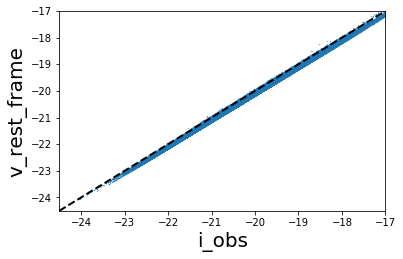

In [59]:
plt.plot(john_0['d_SDSS_i_obs_ext'],john_0['d_mag_V_ext'],".",markersize=0.5,label=r'des $z\sim0.46$',c='C0')
plt.xlim(-24.5,-17.)
plt.ylim(-24.5,-17.)
plt.xlabel('i_obs')
plt.ylabel('v_rest_frame')
plt.plot([-24.5,-17.],[-24.5,-17.],lw=2,c='k',ls='dashed')
plt.tight_layout()
plt.savefig('../plots/009/i_obs_vs_v_restframe.png')
plt.show()